# Syntatic Processing Assignment

 - Analyse medical data set and summarize treatement for each diseases.

In [1]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import spacy
from spacy import displacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

2023-03-22 14:36:51.918843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

In [2]:
def read_file(filename):
    data = []
    with open(filename, "r") as fp:
        data = fp.read()
        data = data.replace("\n\n", "####").replace("\n", " ").replace("####", "\n")
    return data

In [3]:
train_sent   = read_file('./train_sent')
test_sent    = read_file('./test_sent')
train_label = read_file('./train_label')
test_label = read_file('./test_label')

In [4]:
train_sent_proc = train_sent.splitlines()
test_sent_proc = test_sent.splitlines()
train_label_proc = train_label.splitlines()
test_label_proc = test_label.splitlines()

#### Count the number of sentence and labels

In [5]:
print("Num of train sentence: ", len(train_sent_proc))
print("Num of test sentence: ", len(test_sent_proc))
print("Num of train label: ", len(train_label_proc))
print("Num of test label: ", len(test_label_proc))

Num of train sentence:  2599
Num of test sentence:  1056
Num of train label:  2599
Num of test label:  1056


## Concept identification

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
global sent_no
sent_no = 0

In [8]:
def next_sentence(snts, lbls):
    global sent_no
    for n, label in enumerate(lbls):
        if "D" in label and n > sent_no:
            sent_no = n
            break;

In [9]:
def disp_result(snts, lbls, sent_no):
    print(sent_no)
    result = nlp(snts[sent_no])
    for token, label in zip(result, lbls[sent_no].split(' ')):
        print(token.text, "--", token.pos_, "--", label)

    displacy.render(result, style="dep", jupyter = True)

In [10]:
next_sentence(train_sent_proc, train_label_proc)
print(disp_result(train_sent_proc, train_label_proc, sent_no))

12
The -- DET -- O
study -- NOUN -- O
population -- NOUN -- O
included -- VERB -- O
84 -- NUM -- O
women -- NOUN -- O
with -- ADP -- O
gestational -- ADJ -- D
diabetes -- NOUN -- D
, -- PUNCT -- O
ascertained -- VERB -- O
by -- ADP -- O
universal -- ADJ -- O
screening -- NOUN -- O
of -- ADP -- O
all -- DET -- O
women -- NOUN -- O
attending -- VERB -- O
the -- DET -- O
antenatal -- ADJ -- O
clinic -- NOUN -- O
of -- ADP -- O
the -- DET -- O
Hadassah -- PROPN -- O
Medical -- PROPN -- O
Center -- PROPN -- O
, -- PUNCT -- O
over -- ADP -- O
a -- DET -- O
2 -- NUM -- O
- -- PUNCT -- O


None


## Features for CRF

In [11]:
word = []
pos = []
labels = []
sents = []
count = 0
train_disease = []
for sentence, label in tqdm(zip(train_sent_proc, train_label_proc)):
    result = nlp(sentence)
    count += 1
    
    disease_name = []
    for token, lbl in zip(result, label.split(' ')):
        word.append(token.text)
        pos.append(token.pos_)
        labels.append(lbl)
        sents.append(count)
        
        if lbl == 'D' and len(token) > 2:
                disease_name.append(token.text.lower())
    
    if 'D' in set(label):            
        train_disease.append(" ".join(disease_name))

2599it [00:15, 170.26it/s]


In [12]:
train_df = pd.DataFrame({'sentence' : sents, 'word':word,'POS': pos, 'Tag': labels})
train_df.head(5)

,sentence,word,POS,Tag
0,1,All,DET,O
1,1,live,ADJ,O
2,1,births,NOUN,O
3,1,>,X,O
4,1,or,CCONJ,O


In [13]:
word = []
pos = []
labels = []
sents = []
count = 0
test_disease = []
for sentence, label in tqdm(zip(test_sent_proc, test_label_proc)):
    result = nlp(sentence)
    count += 1
    
    disease_name = []
    for token, lbl in zip(result, label.split(' ')):
        word.append(token.text)
        pos.append(token.pos_)
        labels.append(lbl)
        sents.append(count)
        
        if lbl == 'D' and len(token) > 2:
                disease_name.append(token.text.lower())
    
    if 'D' in set(label):            
        test_disease.append(" ".join(disease_name))

1056it [00:06, 170.15it/s]


In [14]:
test_df = pd.DataFrame({'sentence' : sents, 'word':word,'POS': pos, 'Tag': labels})
test_df.head(5)

,sentence,word,POS,Tag
0,1,Furthermore,ADV,O
1,1,",",PUNCT,O
2,1,when,SCONJ,O
3,1,all,DET,O
4,1,deliveries,NOUN,O


In [15]:
print(train_df.word[(train_df['POS'] == 'NOUN') | (train_df['POS'] == 'PROPN')].value_counts().head(25), "\n")
print(test_df.word[(test_df['POS'] == 'NOUN') | (test_df['POS'] == 'PROPN')].value_counts().head(25), "\n")

patients        337
treatment       187
%               152
cancer          115
therapy         107
study            97
disease          87
cell             85
lung             72
effects          61
chemotherapy     58
group            57
TO_SEE           54
results          53
use              52
gene             51
surgery          49
rate             46
survival         46
cases            46
women            46
children         46
risk             45
activity         44
combination      43
Name: word, dtype: int64 

patients        131
treatment        85
%                82
cancer           52
therapy          50
study            46
cell             33
group            30
disease          28
women            27
gene             27
cases            25
results          24
effects          23
lung             22
response         22
age              22
risk             22
use              21
rate             20
TO_SEE           20
chemotherapy     20
effect           20
control      

<AxesSubplot:>

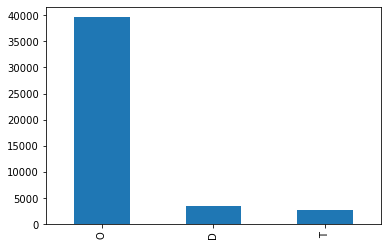

In [16]:
train_df.Tag.value_counts().plot(kind='bar')

In [17]:
tags = train_df.Tag.unique()
tags.tolist()

['O', 'D', 'T']

In [18]:
class SentenceForm():
    def __init__(self, df):
        self.data = df
        self.sent_no = 0
    
        sent_func = lambda s: [(w, p, t) for w, p, t in zip(s['word'].values.tolist(), 
                                                            s['POS'].values.tolist(), 
                                                            s['Tag'].values.tolist())]
        
        grouped = self.data.groupby(self.data.sentence).apply(sent_func)
        self.sentence = [s for s in grouped]
    
    def get_sentence(self):
        try: 
            s = self.sentence[self.sent_no]
            self.sent_no += 1
            return s 
        except:
            return None

## Features and the Labels of sentences

In [19]:
def get_feature(sent, n):
    sent_len = len(sent)
    word = sent[n][0]
    tag = sent[n][1]
    
    feature = {
        #'bias'           : 0.65,
        'word.lower()'   : word.lower(),
        'word[-3:]'      : word[-3:],
        'word[:3]'       : word[:3],     
        'word.istitle()' : word.istitle(),
        'word.isupper()' : word.isupper(),
        'word.isdigit()' : word.isdigit(),            
        'pos'            : tag.lower(),
    }
    if n > 0:
        prev_word = sent[n-1][0]
        prev_tag  = sent[n-1][1]
        feature.update( {
            'prev_word.lower()'   : prev_word.lower(),
            'prev_word.istitle()' : prev_word.istitle(),
            'prev_word.isupper()' : prev_word.isupper(),
            'prev_word.isdigit()' : prev_word.isdigit(),  
            #'prev_word[-3:]'      : prev_word[-3:],
            #'prev_word[:3]'       : prev_word[:3],        
            'prev_pos'            : prev_tag.lower(),
        })
    else:
        feature['start'] = True
        
    if n < (sent_len - 1):
        next_word = sent[n+1][0]
        next_tag  = sent[n+1][1]
        feature.update( {
            'next_word.lower()'   : next_word.lower(),
            'next_word.istitle()' : next_word.istitle(),
            'next_word.isupper()' : next_word.isupper(),
            'next_word.isdigit()' : next_word.isdigit(),
            #'next_word[:-3]'       : next_word[:-3],                        
            #'next_word[:3]'       : next_word[:3],            
            'next_pos'            : next_tag.lower(),
        })
    else:
        feature['end'] = True

    return feature

def get_sentence_feature(sentence):
    features = [get_feature(sentence, n) for n in range(len(sentence))]
    return features

def get_sentence_tag(sentence):
    tags = [tag for word, pos, tag in sentence]
    return tags

In [20]:
TrainSentForm = SentenceForm(train_df)
TestSentForm = SentenceForm(test_df)

In [21]:
train_sentence = TrainSentForm.sentence
test_sentence = TestSentForm.sentence

In [22]:
print(len(train_sentence))
print(len(test_sentence))

2599
1056


In [23]:
print(get_sentence_feature(train_sentence[sent_no]))

[{'word.lower()': 'the', 'word[-3:]': 'The', 'word[:3]': 'The', 'word.istitle()': True, 'word.isupper()': False, 'word.isdigit()': False, 'pos': 'det', 'start': True, 'next_word.lower()': 'study', 'next_word.istitle()': False, 'next_word.isupper()': False, 'next_word.isdigit()': False, 'next_pos': 'noun'}, {'word.lower()': 'study', 'word[-3:]': 'udy', 'word[:3]': 'stu', 'word.istitle()': False, 'word.isupper()': False, 'word.isdigit()': False, 'pos': 'noun', 'prev_word.lower()': 'the', 'prev_word.istitle()': True, 'prev_word.isupper()': False, 'prev_word.isdigit()': False, 'prev_pos': 'det', 'next_word.lower()': 'population', 'next_word.istitle()': False, 'next_word.isupper()': False, 'next_word.isdigit()': False, 'next_pos': 'noun'}, {'word.lower()': 'population', 'word[-3:]': 'ion', 'word[:3]': 'pop', 'word.istitle()': False, 'word.isupper()': False, 'word.isdigit()': False, 'pos': 'noun', 'prev_word.lower()': 'study', 'prev_word.istitle()': False, 'prev_word.isupper()': False, 'prev

In [24]:
print(get_sentence_tag(train_sentence[sent_no]))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Input and Target variables

In [25]:
X_train = [get_sentence_feature(s) for s in train_sentence]
y_train = [get_sentence_tag(s) for s in train_sentence]

X_test = [get_sentence_feature(s) for s in test_sentence]
y_test = [get_sentence_tag(s) for s in test_sentence]

#X = X_train + X_test
#y = y_train + y_test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [26]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    #keep_tempfiles=False,
    all_possible_transitions=True
)

## Building the model

In [27]:
try:
    crf.fit(X_train, y_train)
except:
    pass

In [28]:
tags = train_df.Tag.unique().tolist()

In [29]:
y_pred = crf.predict(X_test)
#print(metrics.flat_classification_report(y_test, y_pred))

## Evaluation

In [30]:
metrics.flat_f1_score(y_test, y_pred, average='weighted',labels = tags)

0.8909197172645661

## Identifying the diseases and treatment using a custom NER

In [31]:
def get_treatement_for_disease(sentences, labels):
    pred_disease = []
    pred_treatement = []
    
    disease_treatment = {}
    
    for snts, label in zip(sentences, labels):
        label_set = set(label)
        if 'D' in  label_set and 'T' in label_set:        
            dis = []
            treat = []
            for word, lbl in zip(snts.split(' '), label):
                if lbl == 'D':
                    dis.append(word.lower())

                if lbl == 'T':
                    treat.append(word)

            dis = " ".join(dis)
            treat = " ".join(treat)
            if len(dis) > 2 and len(treat) > 2:
                pred_disease.append(dis)
                pred_treatement.append(treat)
    
    for disease, treatment in zip(pred_disease, pred_treatement):
        if disease in disease_treatment:
            #print(disease_treatment[disease])
            #disease_treatment[disease].append("#")
            disease_treatment[disease].append(treatment)
            #print(disease_treatment[disease])
        else:
            disease_treatment[disease] = list()
            disease_treatment[disease].append(treatment)

    for key in disease_treatment:
        print("{0} : {1}".format(key.title(), ", ".join(disease_treatment[key])))

get_treatement_for_disease(test_sent_proc, y_pred)

Macrosomic Infants In Gestational Diabetes : good glycemic control
Microcephaly Nonimmune Hydrops Fetalis : Trisomy
Epilepsy : Methylphenidate
Coronary-Artery Disease : Antichlamydial antibiotics
Involved Upper Trapezius : electrical nerve stimulation
Primary Pulmonary Hypertension ( Pph ) : fenfluramines
Intracranial Hemorrhage : double-bolus method
Sore Throat : Antibiotics
Preeclampsia ( Proteinuric Hypertension : intrauterine insemination with donor sperm versus intrauterine insemination with partner
Severe Acquired Hyperammonemia Cancer : organ transplantation and chemotherapy
Years Previously Had : and
Tumor Necrosis : as is seen
Pulmonary Symptoms Attributable To Mediastinal Teratomas : chemotherapy
Non-Obstructive Azoospermia : testicular fine needle aspiration ( TEFNA open biopsy and testicular sperm extraction ( TESE )
Testicular Bleeding : fine needle aspiration , treated TESE
Acute Migraine Treatment : Sumatriptan
Zary Syndrome : Extracorporeal photopheresis
Restenosis : co

## Summary

- Build the model using Custom NER for this dataset  to predict one or multiple treatment for each disease.
- Achieved an __F1 score of 89%__ as prediction result.